Setup, paths, and loading core artifacts

In [5]:
# Cell 1 — Setup, paths, and loading artifacts

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
import sys

# Ensure repo root is on sys.path so 'src' can be imported from notebooks/
# If your notebook is under the repo's 'notebooks/' folder this goes up one level.
nb_cwd = Path.cwd()
repo_root = nb_cwd
if not (repo_root / "src").exists():
    repo_root = nb_cwd.parent  # move up if notebook CWD is notebooks/
sys.path.insert(0, str(repo_root.resolve()))
print("Added to sys.path:\", sys.path[0]")

plt.style.use("seaborn-v0_8-whitegrid")

# Utility: find Poseidon project root
def find_project_root(project_name="Poseidon"):
    cwd = Path.cwd().resolve()
    project_name_l = project_name.lower()
    for p in [cwd] + list(cwd.parents):
        if p.name.lower() == project_name_l:
            return p
    if cwd.name.lower() == "notebooks" and cwd.parent.exists():
        return cwd.parent
    raise FileNotFoundError(f"Could not locate project root '{project_name}'. Starting cwd: {cwd}")

ROOT = find_project_root("Poseidon")

DATA      = ROOT / "data"
RAW       = DATA / "raw"
INTERIM   = DATA / "interim"
PROCESSED = DATA / "processed"
ART       = ROOT / "artifacts"
MODEL_REG = ART / "model_registry"
REPORTS   = ROOT / "reports"

print("ROOT:", ROOT)

# Load Montería trusted dataset (with pseudo-labels + soft sensors)
mon_trust_path = INTERIM / "monteria_pseudolabeled_trusted.csv"
df_mon = pd.read_csv(mon_trust_path, parse_dates=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
print("Montería trusted shape:", df_mon.shape)
display(df_mon.head(3))

# Load hybrid forecast bundle (Model 3)
hybrid_path = MODEL_REG / "model3_forecast_hybrid_bundle.joblib"
hybrid = joblib.load(hybrid_path)

feature_cols   = hybrid["feature_cols"]
SENSORS        = hybrid["sensors"]
HISTORY_STEPS  = hybrid["history_steps"]
ROLL_WINDOWS   = hybrid["roll_windows"]
USE_SLOPE      = hybrid["use_slope"]
HORIZONS       = hybrid["horizons"]
TAB_SCALER     = hybrid["scaler_tabular"]
SENS_SCALER    = hybrid["scaler_sensors"]
HYBRID_MODELS  = hybrid["hybrid_models"]
risk_col       = hybrid["risk_label_column"]

print("SENSORS:", SENSORS)
print("HORIZONS:", HORIZONS)

# Import hybrid runtime forecaster (from src/runtime_forecast.py)
from src.runtime_forecast import predict_future_risk


Added to sys.path:", sys.path[0]
ROOT: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon
Montería trusted shape: (4345, 17)


,timestamp,temperature,pH,turbidity_proxy,predicted_do,predicted_nh3,p_high_teacher,weak_p_high,p_high_cal,risk_argmax,risk_blended,conf_score,high_confidence,proba_HIGH,proba_LOW,proba_MEDIUM,keep_for_training
0,2025-01-01 00:00:00,27.598028,7.937212,0.553292,4.170613,0.029451,0.0,0.625,0.177528,MEDIUM,LOW,0.822472,False,0.0,0.022465,0.977535,True
1,2025-01-01 00:30:00,27.217041,7.872365,0.677565,4.170613,0.028561,0.0,0.625,0.177528,MEDIUM,LOW,0.822472,False,0.0,0.022465,0.977535,True
2,2025-01-01 01:00:00,27.688613,7.941378,0.370436,4.170613,0.030651,0.0,0.500,0.140539,MEDIUM,LOW,0.859461,True,0.0,0.022465,0.977535,True


SENSORS: ['temperature', 'pH', 'turbidity_proxy', 'predicted_do', 'predicted_nh3']
HORIZONS: {'+1h': 2, '+6h': 12, '+24h': 48, '+3d': 144}


Load Model 1 (risk classifier) correctly

In [6]:
# Cell 2 — Load risk classifier (Model 1) from bundle

model1_path = MODEL_REG / "model1_risk_classifier.joblib"
risk_bundle = joblib.load(model1_path)

risk_model      = risk_bundle["model"]        # CalibratedClassifierCV
risk_features   = risk_bundle["features"]     # list of feature names
bundle_classes  = risk_bundle["classes"]      # ['HIGH','LOW','MEDIUM'] (bundle view)
risk_thresholds = risk_bundle.get("thresholds", {})  # e.g. {'HIGH': 0.3}
risk_version    = risk_bundle.get("version", "unknown")
risk_notes      = risk_bundle.get("notes", "")

print("Risk model version:", risk_version)
print("Bundle classes:", bundle_classes)
print("Risk thresholds:", risk_thresholds)
print("Notes:", risk_notes)

# The classifier itself has its own class order for predict_proba
model_class_order = risk_model.classes_
print("Model classes_ order:", model_class_order)

def get_risk_label_from_proba(proba_vec):
    """
    Given a proba vector aligned with risk_model.classes_, return label with max probability.
    """
    idx = int(np.argmax(proba_vec))
    return model_class_order[idx]


Risk model version: model1_risk_classifier_v1
Bundle classes: ['HIGH', 'LOW', 'MEDIUM']
Risk thresholds: {'HIGH': 0.3}
Notes: Calibrated (isotonic); thresholds tuned to emphasize HIGH recall.
Model classes_ order: ['HIGH' 'LOW' 'MEDIUM']


Feature preparation for Model 1

We align exactly with risk_features and don’t use any scaler.

In [7]:
# Cell 3 — Prepare features for Model 1 from a single row

def prepare_risk_features_from_row(row: pd.Series) -> np.ndarray:
    """
    Build feature vector for risk_model from a single sensor row,
    aligned with risk_features stored in the bundle.
    If some engineered feature is missing, default to 0.0.
    """
    vals = []
    for f in risk_features:
        if f in row.index:
            vals.append(row[f])
        else:
            # You can extend this block to compute engineered features if needed.
            vals.append(0.0)
    X = np.array(vals, dtype=float).reshape(1, -1)
    return X

# Quick sanity test on the last row
test_row = df_mon.iloc[-1]
X_test = prepare_risk_features_from_row(test_row)
proba_test = risk_model.predict_proba(X_test)[0]
print("Test proba:", dict(zip(model_class_order, proba_test)))
print("Predicted label:", get_risk_label_from_proba(proba_test))


Test proba: {'HIGH': np.float64(0.0), 'LOW': np.float64(0.013026819923371647), 'MEDIUM': np.float64(0.9869731800766284)}
Predicted label: MEDIUM


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


Domain thresholds for explainability & rules

These are for DO, NH₃, etc. You can tweak the numbers later.

In [8]:
# Cell 4 — Parameter thresholds (used for explainability and recs)

PARAM_THRESHOLDS = {
    "predicted_do": {
        "low_critical": 3.0,   # < 3.0 mg/L: very dangerous
        "low_warning":  4.0,   # 3.0–4.0 mg/L: risky
        "optimal_min":  4.5,   # target comfort band
        "optimal_max":  7.5,
    },
    "predicted_nh3": {
        "high_critical": 0.5,  # > 0.5 mg/L: very bad
        "high_warning":  0.25, # 0.25–0.5 mg/L: watch
    },
    "temperature": {
        "low": 24.0,
        "high": 32.0,
    },
    "pH": {
        "low": 6.5,
        "high": 9.0,
    },
    "turbidity_proxy": {
        "high_warning": 0.7,   # adjust based on your scaling
    }
}

PARAM_THRESHOLDS


{'predicted_do': {'low_critical': 3.0,
  'low_warning': 4.0,
  'optimal_min': 4.5,
  'optimal_max': 7.5},
 'predicted_nh3': {'high_critical': 0.5, 'high_warning': 0.25},
 'temperature': {'low': 24.0, 'high': 32.0},
 'pH': {'low': 6.5, 'high': 9.0},
 'turbidity_proxy': {'high_warning': 0.7}}

Trend analyzer on recent window

This gives us deltas and simple slopes.

In [9]:
# Cell 5 — Trend analysis over recent window

def compute_trends(recent_df: pd.DataFrame, horizon_hours: float = 6.0):
    """
    Given recent_df with timestamp + core sensors, compute simple trends
    over the last `horizon_hours` hours.
    Returns:
        dict: {param: {"start", "end", "delta", "slope", "n_points"}}
    """
    recent_df = recent_df.sort_values("timestamp").reset_index(drop=True)
    if len(recent_df) < 2:
        return {}

    t_end = recent_df["timestamp"].max()
    window_start = t_end - pd.Timedelta(hours=horizon_hours)

    window_df = recent_df[recent_df["timestamp"] >= window_start]
    if len(window_df) < 2:
        window_df = recent_df.tail(2)

    trends = {}

    for col in ["temperature", "pH", "turbidity_proxy", "predicted_do", "predicted_nh3"]:
        arr = window_df[col].values.astype(float)
        start = arr[0]
        end   = arr[-1]
        delta = end - start

        x = np.arange(len(arr))
        if len(arr) > 1:
            slope = np.polyfit(x, arr, 1)[0]
        else:
            slope = 0.0

        trends[col] = {
            "start": float(start),
            "end": float(end),
            "delta": float(delta),
            "slope": float(slope),
            "n_points": int(len(arr)),
        }

    return trends

# Quick test
recent_test = df_mon.tail(24)[["timestamp","temperature","pH","turbidity_proxy","predicted_do","predicted_nh3"]]
compute_trends(recent_test, horizon_hours=6)


{'temperature': {'start': 27.75283997884069,
  'end': 26.90766096700466,
  'delta': -0.8451790118360307,
  'slope': 0.027936892074199842,
  'n_points': 13},
 'pH': {'start': 7.792298734865057,
  'end': 8.264689025204632,
  'delta': 0.47239029033957447,
  'slope': 0.0034187897921192237,
  'n_points': 13},
 'turbidity_proxy': {'start': 0.5477966958019864,
  'end': 0.4342564437374009,
  'delta': -0.11354025206458551,
  'slope': 0.0057106314115466135,
  'n_points': 13},
 'predicted_do': {'start': 4.170613424171694,
  'end': 3.9028535872871646,
  'delta': -0.2677598368845291,
  'slope': -0.004310717485739158,
  'n_points': 13},
 'predicted_nh3': {'start': 0.0238260913722995,
  'end': 0.0111246677325858,
  'delta': -0.0127014236397137,
  'slope': 0.0005634280989918301,
  'n_points': 13}}

Explain current risk (WHY)

This combines: Model 1 predicted probabilities, Threshold logic (DO, NH₃, etc.), Trend changes

In [12]:
# Cell 6 — Explain current risk (WHY) using Model 1 + thresholds + trends

def explain_current_risk(recent_df: pd.DataFrame, horizon_hours: float = 6.0):
    """
    Explain why current risk is LOW/MEDIUM/HIGH based on:
      - risk classifier output
      - parameter thresholds
      - last-horizon trends
    """
    recent_df = recent_df.sort_values("timestamp").reset_index(drop=True)
    last = recent_df.iloc[-1]

    # 1) Risk classifier
    X_risk = prepare_risk_features_from_row(last)
    proba  = risk_model.predict_proba(X_risk)[0]
    label_argmax = get_risk_label_from_proba(proba)

    # Optionally apply HIGH threshold logic
    p_high = float(proba[model_class_order.tolist().index("HIGH")]) if "HIGH" in model_class_order else 0.0
    high_thr = risk_thresholds.get("HIGH", 0.3)
    if p_high >= high_thr:
        final_label = "HIGH"
    else:
        final_label = label_argmax

    # 2) Trends
    trends = compute_trends(recent_df, horizon_hours=horizon_hours)

    # 3) Build explanation factors
    factors = []

    # DO level
    do = float(last["predicted_do"])
    do_thr = PARAM_THRESHOLDS["predicted_do"]
    if do < do_thr["low_critical"]:
        factors.append(("PRIMARY", f"Dissolved oxygen critically low ({do:.2f} mg/L)."))
    elif do < do_thr["low_warning"]:
        factors.append(("PRIMARY", f"Dissolved oxygen in risky zone ({do:.2f} mg/L)."))

    # NH3 level
    nh3 = float(last["predicted_nh3"])
    nh3_thr = PARAM_THRESHOLDS["predicted_nh3"]
    if nh3 > nh3_thr["high_critical"]:
        factors.append(("PRIMARY", f"Ammonia critically high ({nh3:.3f} mg/L)."))
    elif nh3 > nh3_thr["high_warning"]:
        factors.append(("CONTRIBUTING", f"Ammonia elevated ({nh3:.3f} mg/L)."))

    # Temperature
    temp = float(last["temperature"])
    temp_thr = PARAM_THRESHOLDS["temperature"]
    if temp > temp_thr["high"]:
        factors.append(("CONTRIBUTING", f"Water temperature high ({temp:.1f} °C)."))
    elif temp < temp_thr["low"]:
        factors.append(("CONTRIBUTING", f"Water temperature low ({temp:.1f} °C)."))

    # pH
    ph = float(last["pH"])
    ph_thr = PARAM_THRESHOLDS["pH"]
    if ph < ph_thr["low"] or ph > ph_thr["high"]:
        factors.append(("CONTRIBUTING", f"pH out of comfort range ({ph:.2f})."))

    # Turbidity
    turb = float(last["turbidity_proxy"])
    turb_thr = PARAM_THRESHOLDS["turbidity_proxy"]["high_warning"]
    if turb > turb_thr:
        factors.append(("SECONDARY", f"Turbidity elevated (proxy={turb:.3f})."))

    # 4) Trend-based insights
    for col, info in trends.items():
        delta = info["delta"]
        npts = info["n_points"]
        if col == "predicted_do" and delta < -0.5:
            factors.append(("PRIMARY", f"Dissolved oxygen dropped {delta:.2f} mg/L over last {npts} readings."))
        if col == "predicted_nh3" and delta > 0.1:
            factors.append(("CONTRIBUTING", f"Ammonia rising by {delta:.3f} mg/L in recent window."))

    explanation = {
        "risk_label": final_label,
        "risk_label_argmax": label_argmax,
        "risk_proba": {cls: float(p) for cls, p in zip(model_class_order, proba)},
        "p_high": p_high,
        "high_threshold": high_thr,
        "factors": factors,
    }
    return explanation

# Quick test explainability on last HISTORY_STEPS
recent_explain = df_mon.tail(HISTORY_STEPS)[
    ["timestamp","temperature","pH","turbidity_proxy","predicted_do","predicted_nh3"]
]
ex = explain_current_risk(recent_explain, horizon_hours=6)
ex


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


{'risk_label': 'MEDIUM',
 'risk_label_argmax': 'MEDIUM',
 'risk_proba': {'HIGH': 0.0,
  'LOW': 0.013026819923371647,
  'MEDIUM': 0.9869731800766284},
 'p_high': 0.0,
 'high_threshold': 0.3,
 'factors': [('PRIMARY', 'Dissolved oxygen in risky zone (3.90 mg/L).')]}

Recommendation Engine (WHAT TO DO)

We now map conditions → actions.

In [13]:
# Cell 7 — Recommendation engine (WHAT TO DO)

RECOMMENDATION_RULES = {
    "PRIMARY_DO_LOW": {
        "trigger": lambda ctx: ctx["last"]["predicted_do"] < PARAM_THRESHOLDS["predicted_do"]["low_warning"],
        "immediate": [
            "Increase aeration immediately.",
            "Avoid feeding until dissolved oxygen stabilizes.",
        ],
        "investigation": [
            "Check aerator performance and power supply.",
            "Observe fish behavior near the surface (gasping).",
        ],
        "preventive": [
            "Schedule DO measurements at dawn and late afternoon daily.",
            "Optimize feeding schedule to reduce excess organic load.",
        ],
    },
    "PRIMARY_NH3_HIGH": {
        "trigger": lambda ctx: ctx["last"]["predicted_nh3"] > PARAM_THRESHOLDS["predicted_nh3"]["high_warning"],
        "immediate": [
            "Reduce feeding by 50% for the next 24 hours.",
            "Increase partial water exchange if possible.",
        ],
        "investigation": [
            "Check for uneaten feed and sludge accumulation.",
            "Review recent changes in feeding or stocking density.",
        ],
        "preventive": [
            "Implement regular pond bottom cleaning and sludge removal.",
            "Align stocking densities with pond carrying capacity.",
        ],
    },
    "TEMP_OUT_OF_RANGE": {
        "trigger": lambda ctx: (
            ctx["last"]["temperature"] > PARAM_THRESHOLDS["temperature"]["high"]
            or ctx["last"]["temperature"] < PARAM_THRESHOLDS["temperature"]["low"]
        ),
        "immediate": [
            "Avoid major feeding during hottest hours of the day.",
        ],
        "investigation": [
            "Check shade, water depth, and inflow temperature.",
        ],
        "preventive": [
            "Plan partial water exchange during cooler hours.",
            "Increase shading structures if persistent high temperatures.",
        ],
    },
}

def _dedup(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

def generate_recommendations(recent_df: pd.DataFrame, explanation: dict):
    recent_df = recent_df.sort_values("timestamp").reset_index(drop=True)
    last = recent_df.iloc[-1].to_dict()
    ctx = {
        "last": last,
        "explanation": explanation,
    }

    immediate = []
    investigation = []
    preventive = []

    for name, rule in RECOMMENDATION_RULES.items():
        try:
            if rule["trigger"](ctx):
                immediate.extend(rule.get("immediate", []))
                investigation.extend(rule.get("investigation", []))
                preventive.extend(rule.get("preventive", []))
        except Exception as e:
            print(f"Rule {name} raised error: {e}")

    return {
        "immediate": _dedup(immediate),
        "investigation": _dedup(investigation),
        "preventive": _dedup(preventive),
    }

# Test recommendations on same recent window
recs = generate_recommendations(recent_explain, ex)
recs


{'immediate': ['Increase aeration immediately.',
  'Avoid feeding until dissolved oxygen stabilizes.'],
 'investigation': ['Check aerator performance and power supply.',
  'Observe fish behavior near the surface (gasping).'],
 'preventive': ['Schedule DO measurements at dawn and late afternoon daily.',
  'Optimize feeding schedule to reduce excess organic load.']}

Combine: Forecast + Explain + Recommend + Alert

This is your Decision Support payload — exactly what the API/dashboard should use.

In [14]:
# Cell 8 — Full decision-support payload (forecast + explain + recs + alert)

def build_decision_support_payload(recent_df: pd.DataFrame):
    """
    recent_df: must include >= HISTORY_STEPS rows, with:
      ['timestamp','temperature','pH','turbidity_proxy','predicted_do','predicted_nh3']
    Returns:
      dict with:
        - current_risk (label + proba + factors)
        - forecast (per horizon)
        - recommendations (immediate/investigation/preventive)
        - alert_level
        - latest_timestamp
    """
    recent_df = recent_df.sort_values("timestamp").reset_index(drop=True)
    assert len(recent_df) >= HISTORY_STEPS, f"Need >= {HISTORY_STEPS} rows, got {len(recent_df)}"

    # 1) Current explainability (WHY)
    explanation = explain_current_risk(recent_df, horizon_hours=6)

    # 2) Future risk forecast using hybrid engine
    forecast = predict_future_risk(recent_df)

    # 3) Recommendations based on current state
    recommendations = generate_recommendations(recent_df, explanation)

    # 4) Alert logic
    max_forecast = max(forecast.values())
    current_label = explanation["risk_label"]

    if current_label == "HIGH" or max_forecast > 0.7:
        alert_level = "CRITICAL"
    elif max_forecast > 0.4:
        alert_level = "WARNING"
    else:
        alert_level = "INFO"

    payload = {
        "current_risk": explanation,
        "forecast": forecast,
        "recommendations": recommendations,
        "alert_level": alert_level,
        "latest_timestamp": str(recent_df["timestamp"].max()),
    }
    return payload

# Test full pipeline on last HISTORY_STEPS rows of Montería
recent_panel = df_mon.tail(HISTORY_STEPS)[
    ["timestamp","temperature","pH","turbidity_proxy","predicted_do","predicted_nh3"]
]
panel = build_decision_support_payload(recent_panel)
panel


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


{'current_risk': {'risk_label': 'MEDIUM',
  'risk_label_argmax': 'MEDIUM',
  'risk_proba': {'HIGH': 0.0,
   'LOW': 0.013026819923371647,
   'MEDIUM': 0.9869731800766284},
  'p_high': 0.0,
  'high_threshold': 0.3,
  'factors': [('PRIMARY', 'Dissolved oxygen in risky zone (3.90 mg/L).')]},
 'forecast': {'+1h': 0.15413106977939606,
  '+24h': 0.14396072529619838,
  '+3d': 0.14479297058354687,
  '+6h': 0.14841479063034058},
 'recommendations': {'immediate': ['Increase aeration immediately.',
   'Avoid feeding until dissolved oxygen stabilizes.'],
  'investigation': ['Check aerator performance and power supply.',
   'Observe fish behavior near the surface (gasping).'],
  'preventive': ['Schedule DO measurements at dawn and late afternoon daily.',
   'Optimize feeding schedule to reduce excess organic load.']},
 'alert_level': 'INFO',
 'latest_timestamp': '2025-04-01 12:00:00'}

Simple visualization of recent trends

Not required, but nice for your report.

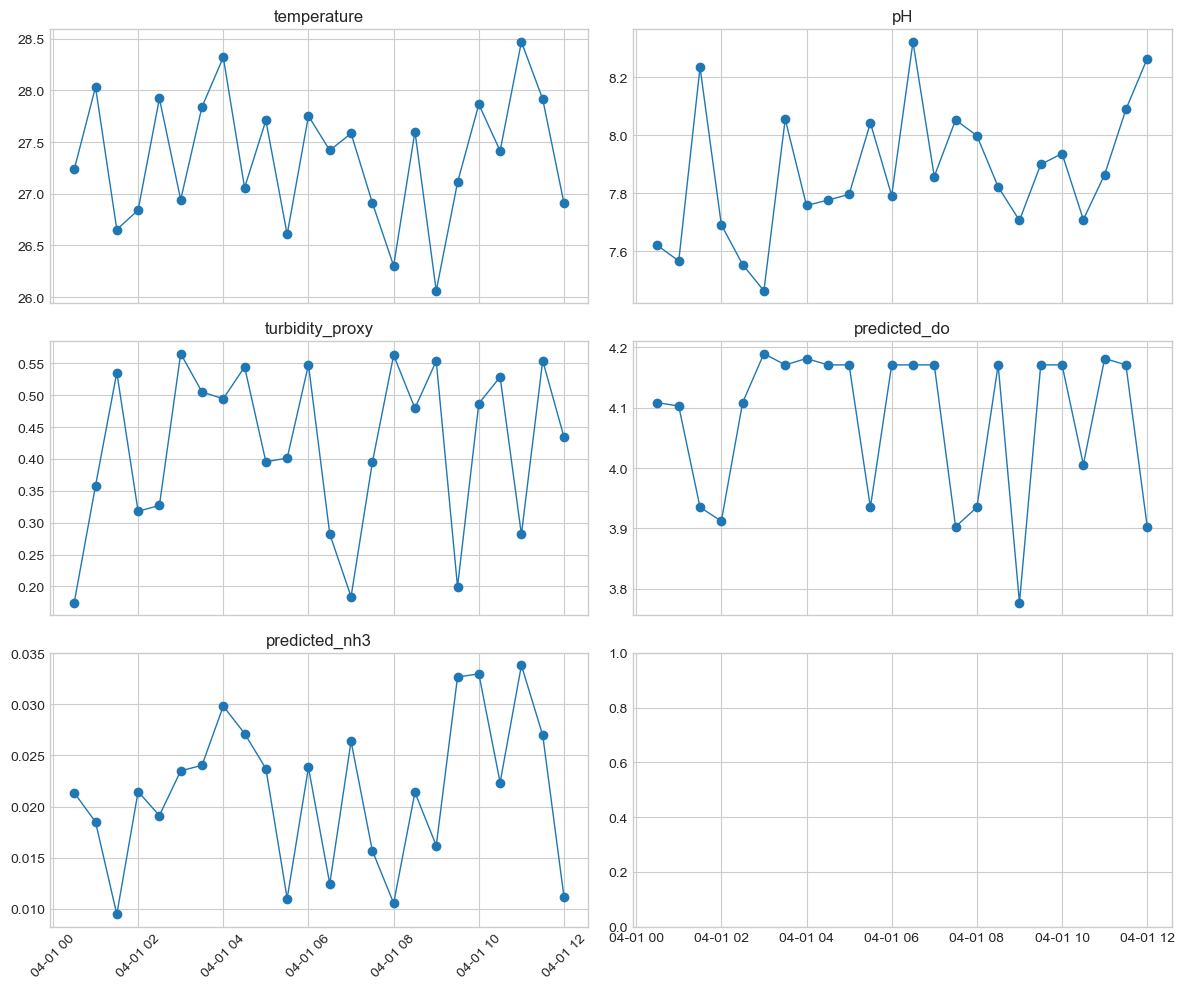

Forecast P(HIGH) per horizon:
  +1h: 0.154
  +24h: 0.144
  +3d: 0.145
  +6h: 0.148


In [15]:
# Cell 9 — Quick plot of recent trends and risk forecast (optional)

def plot_recent_trends(recent_df, forecast_dict):
    recent_df = recent_df.sort_values("timestamp").reset_index(drop=True)

    fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
    axes = axes.ravel()

    cols = ["temperature","pH","turbidity_proxy","predicted_do","predicted_nh3"]
    for ax, col in zip(axes, cols):
        ax.plot(recent_df["timestamp"], recent_df[col], marker="o", linewidth=1.0)
        ax.set_title(col)
        ax.tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    print("Forecast P(HIGH) per horizon:")
    for h, val in forecast_dict.items():
        print(f"  {h}: {val:.3f}")

plot_recent_trends(recent_panel, panel["forecast"])
